In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

cond A =  16210.7227202128
monolithic error = 5.987167834308295e-16
u(0) = 0.0
du/dx(L) = 0.0


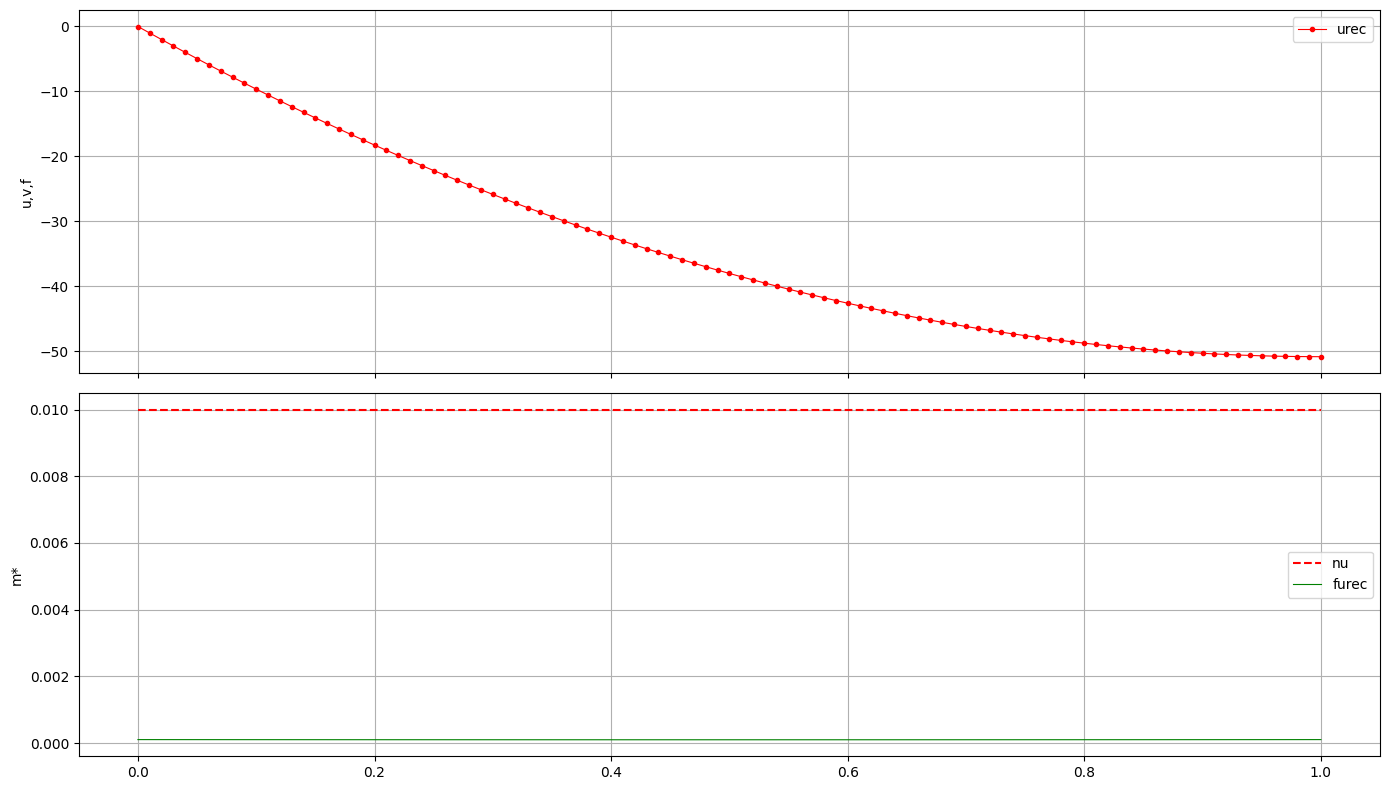

In [20]:
def nu(x):
    return 0.01  + 0.*np.cos(4*x)

def reconstruct(sol, x):
    n = len(sol)
    rec = 0.0*x
    for i, val in enumerate(x):
        if i == 0:
            rec[0] = 1.5*sol[0] - 0.5*sol[1]
        elif i==len(x)-1:
            rec[i] = 1.5*sol[-1] - 0.5*sol[-2]
        else:
            rec[i] = 0.5*(sol[i-1]+sol[i])
    return rec

def print_BC():
    if left_condition_type_u == 'dirichlet':
        print('u(0) =', left_condition_value_u)
    else:
        print('du/dx(0) =', left_condition_value_u)

    if right_condition_type_u == 'dirichlet':
        print('u(L) =', right_condition_value_u)
    else:
        print('du/dx(L) =', right_condition_value_u)

def diag(k, m, left_condition_type, right_condition_type):
    tmp = 0.0
    if k==0:
        if left_condition_type=='dirichlet':
            tmp = -m(dx) -2.0*m(0.0) 
        elif left_condition_type=='neumann':
            tmp = -m(dx)
    elif k==N-1:
        if right_condition_type=='dirichlet':
            tmp = -(2.0*m(L)+m(L-dx))
        elif right_condition_type=='neumann':
            tmp = -m(L-dx)
    else:
        tmp = -( m((k+1)*dx) + m(k*dx) )
    return tmp

def upper(k, m, left_condition_type, right_condition_type):
    if k==0:
        if left_condition_type=='dirichlet':
            return m(dx)
        elif left_condition_type=='neumann':
            return m(dx)
    else:
        return m(dx*(1+k))

def lower(k, m, left_condition_type, right_condition_type):
    if k==N-1:
        if left_condition_type=='dirichlet':
            return m(L-dx)
        elif left_condition_type=='neumann':
            return m(L-dx)
    else:
        return m(dx*k)

def f(y):
    return 1.0 + 0.2*np.square(y-0.5)
    
def source_u():
    tmp = np.zeros(N)
    for i,y in enumerate(xc):
        tmp[i] = 0.5*np.square(dx)*(f(x[i])+f(x[i+1]))
    return tmp

def known_term(source, m, left_condition_type, left_condition_value, right_condition_type, right_condition_value):
    tmp = source
    if left_condition_type=='dirichlet':
        tmp[0] = tmp[0] - 2.0*m(0.0)*left_condition_value
    elif left_condition_type=='neumann':
        tmp[0] = tmp[0] + dx*m(0.0)*left_condition_value
    if right_condition_type=='dirichlet':
        tmp[N-1] = tmp[N-1] -2.0*m(L)*right_condition_value
    elif right_condition_type=='neumann':
        tmp[N-1] = tmp[N-1] - dx*m(L)*right_condition_value
    return tmp
        
left_condition_type_u = 'dirichlet'
left_condition_value_u = 0.0
right_condition_type_u = 'neumann'
right_condition_value_u = 0.0


L = 1.0

fig, (ax2, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(14,8), dpi=100)

N = 100
dx = np.divide(L,N)
x = np.linspace(0,L,N+1)
xc = np.linspace(0.5*dx,L-0.5*dx,N)

diagA = np.zeros(N)
upperA = np.zeros(N-1)
lowerA = np.zeros(N-1)

for k in range(N):
    diagA[k] = diag(k, nu, left_condition_type_u, right_condition_type_u)

for k in range(N-1):
    upperA[k] = upper(k, nu, left_condition_type_u, right_condition_type_u)
    lowerA[k] = upper(k, nu, left_condition_type_u, right_condition_type_u)

A = diags([diagA, upperA, lowerA], [0, -1, 1])
A = A.toarray()

fu = np.zeros(N)
fu = known_term(source_u(), nu, left_condition_type_u, left_condition_value_u, right_condition_type_u, right_condition_value_u)

u = linalg.solve(A, fu)
u_rec = reconstruct(u, x)

print("cond A = ", np.linalg.cond(A))
print(f"monolithic error = {np.linalg.norm(fu-np.dot(A,u))}")

markersize = 20
linewidth = 0.8

ax1.set_xlabel('')
ax1.set_ylabel('m*')
ax1.plot(x, nu(x), '--r', label='nu')
#ax1.plot(x, 0*x, '.', color='k', label='faces', markersize=10.0)
#ax1.plot(xc, 0*xc, 'x', color='k', label='cell centers')
#ax1.plot(xc, fu, '_g', label='fu', markersize=markersize)
ax1.plot(x, reconstruct(fu, x), '-g' , label='furec', linewidth=linewidth)

color = 'k'
#ax2.plot(xc, u, '_r' , label='u', markersize=markersize)
ax2.plot(x, u_rec, '.-r' , label='urec', linewidth=linewidth)

print_BC()

ax2.set_ylabel('u,v,f')
#ax2.set_ylim(bottom=0.0)
#ax2.set_xlim([-0.001,0.1])
ax1.legend()
ax2.legend()    
ax1.grid()
ax2.grid(axis='both', which='both')
fig.tight_layout()

#fig1, ax = plt.subplots(1, 1, figsize=(10,5))
#cax = ax.matshow(Z)
#fig1.colorbar(cax, ax=ax)
#plt.savefig('matrix.pdf')